# Matrix Factorization

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, "..")

In [21]:
from util.data_loader import DataLoader
rating = DataLoader.train_rating()
test = DataLoader.test_rating()
item = DataLoader.item()

In [22]:
rating_df = pd.DataFrame(rating)
item_df = pd.DataFrame(item)

In [23]:
user_item = rating_df.merge(item_df, on="item_id", how="right")
matrix = user_item.pivot(index="user_id", columns="item_id", values="rating")
matrix.drop(matrix.index[0], inplace=True)
matrix

item_id,1,2,3,4,5,6,7,8,9
user_id,,,,,,,,,
1.0,NaN,4.0,3.0,1.0,2.0,NaN,4.0,NaN,NaN
2.0,5.0,5.0,4.0,NaN,3.0,3.0,5.0,4.0,NaN
3.0,4.0,NaN,5.0,3.0,2.0,NaN,NaN,3.0,NaN
4.0,NaN,3.0,NaN,2.0,1.0,1.0,3.0,NaN,NaN
5.0,2.0,1.0,2.0,4.0,NaN,3.0,2.0,NaN,NaN


In [24]:
N = len(matrix.index)
M = len(matrix.columns)
K = 4

In [25]:
P = np.random.rand(N,K)
P

array([[0.77673393, 0.12659369, 0.40681338, 0.03826449],
       [0.22867042, 0.54451727, 0.65405082, 0.68127908],
       [0.57438267, 0.03277545, 0.69562733, 0.97008074],
       [0.90977126, 0.23718389, 0.71568869, 0.24807168],
       [0.55772936, 0.72150685, 0.49011787, 0.51760791]])

In [26]:
Q = np.random.rand(M,K)
Q.T

array([[0.72679827, 0.12792939, 0.20044343, 0.91208279, 0.18911402,
        0.43805131, 0.21817851, 0.63590788, 0.24230681],
       [0.79675801, 0.93726645, 0.16112928, 0.93758433, 0.19697146,
        0.79441444, 0.8885616 , 0.52437501, 0.39469322],
       [0.81372021, 0.25567527, 0.82481544, 0.02573991, 0.26792445,
        0.37159439, 0.21569344, 0.52966174, 0.76583744],
       [0.81787456, 0.04274719, 0.86809773, 0.70949052, 0.99709261,
        0.58514883, 0.78285961, 0.13657006, 0.44423247]])

In [27]:
# 最適化
# エポック数
steps = 2000
# 学習率
alpha = 0.0002
beta = 0.01

Q = Q.T
user_item_matrix = matrix.copy()

In [28]:
user_id = matrix.index.values
item_id = matrix.columns.values
E = []
for step in range(steps):
    for i in range(len(matrix.index)):
        for j in range(len(matrix.columns)):
            if ~np.isnan(matrix.loc[user_id[i],item_id[j]]):
                eij = matrix.loc[user_id[i],item_id[j]] - np.dot(P[i,:],Q[:,j])
                for k in range(K):
                    P[i,k] = P[i,k]+alpha*(2*eij*Q[k,j]-beta*P[i,k])
                    Q[k,j] = Q[k,j]+alpha*(2*eij*P[i,k]-beta*Q[k,j])
    eR = np.dot(P,Q)
    eE = user_item_matrix - eR
    E.append(np.nansum(eE))
    e = 0
    for i in range(len(matrix.index)):
        for j in range(len(matrix.columns)):
            if ~np.isnan(matrix.loc[user_id[i],item_id[j]]):
                e = e + pow(matrix.loc[user_id[i],item_id[j]]-np.dot(P[i,:],Q[:,j]),2)
                for k in range(K):
                    e = e + (beta/2)*(pow(P[i,k],2)+pow(Q[k,j],2))
                
    if e < 0.001:
        break

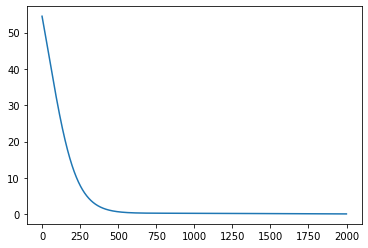

In [29]:
plt.plot(np.arange(len(E)), E)
plt.show()

In [30]:
E[-1]

0.09457058432116416

In [31]:
R = np.dot(P,Q)

In [32]:
test_df = pd.DataFrame(test)
test_df_copy = test_df.copy()

In [33]:
from collections import defaultdict

K_ITEMS = 3
THETA = 3
pred_user2items = defaultdict(list)
user_id2index = dict(zip(matrix.index, range(len(matrix.index))))
item_id2index = dict(zip(matrix.columns, range(len(matrix.columns))))
Ui = rating_df.groupby("user_id").agg({"item_id": list})["item_id"].to_dict()

scores = []
for u in matrix.index:
    Ui_not = list(set(item_id) ^ set(Ui[u]))
    pred_items = {i: R[user_id2index[u],item_id2index[i]] for i in Ui_not}
    pred_items = dict(sorted(pred_items.items(), key=lambda i:i[1], reverse=True)[:K_ITEMS])
    pred_items = {i: score for i, score in pred_items.items() if score >= THETA}
    for i in pred_items:
        pred_user2items[u].append(i)
    for i in matrix.columns:
        if np.isnan(matrix.loc[u,i]):
            scores.append(R[user_id2index[u], item_id2index[i]])

In [34]:
test_df["pred_rating"] = scores
test_df_copy = test_df_copy.sort_values(by=["user_id", "rating"], ascending=[True, False]).groupby('user_id').head(3)
test_user2items = test_df_copy[test_df_copy["rating"] >= 3].groupby('user_id').agg({"item_id":list})["item_id"].to_dict()


In [35]:
# precision
def precision_at_k(test_items: list, pred_items: list, k: int) -> float:
    if K == 0:
        return 0.0
    p_at_k = (len(set(test_items) & set(pred_items[:k]))) / k
    return p_at_k

scores = []
for user_id in test_user2items.keys():
    p_at_k = precision_at_k(test_user2items[user_id], pred_user2items[user_id], 3)
    scores.append(p_at_k)
    
precision = np.mean(scores)
print(f'precision: {precision:.3f}')

precision: 0.267


In [36]:
# recall
def recall_at_k(test_items: list, pred_items: list, k: int) -> float:
    if len(test_items) == 0 or k == 0:
        return 0.0
    r_at_k = (len(set(test_items) & set(pred_items[:k]))) / len(test_items)
    return r_at_k
scores = []
for user_id in test_user2items.keys():
    r_at_k = recall_at_k(test_user2items[user_id], pred_user2items[user_id], 3)
    scores.append(r_at_k)
    
recall = np.mean(scores)
print(f'recall: {recall:.3f}')

recall: 0.300


In [37]:
# rmse
from sklearn.metrics import mean_squared_error

true_rating = test_df["rating"]
pred_rating = test_df["pred_rating"]
rmse = np.sqrt(mean_squared_error(true_rating, pred_rating))
print(f'rmse: {rmse:.3f}')

rmse: 1.251


In [38]:
ranking_df = test_df.sort_values(by=["user_id", "rating"], ascending=[True, False])

def DCG(true: np.array, pred: np.array, k: int) -> float:
    if (len(true) < k):
        k = len(true)
    dcg = np.sum([2**pred[k]-1/np.log2(k+2) for k in range(k)])
    idcg = np.sum([2**true[k]-1/np.log2(k+2) for k in range(k)])
    return dcg / idcg

nDCGu = []
for user_id in matrix.index:
    true_ranking = ranking_df[ranking_df["user_id"]==user_id]["rating"].values
    pred_ranking = ranking_df[ranking_df["user_id"]==user_id]["pred_rating"].values
    DCGi = DCG(true_ranking, pred_ranking, 3)
    nDCGu.append(DCGi)
DCGu = np.mean(nDCGu)
print(f'DCGu: {DCGu}')

DCGu: 0.6470075639845357
